## Visualization script for multiplayer Type Through the Bible files

By Ken Burchfiel

Released under the MIT license

Note: this script, though developed as a Jupyter Notebook to make development and testing easier, is meant to be called as a Python file within a terminal/command prompt with a multiplayer test results file as its sole argument. Here's an example of what this function call may look like on Linux when the current directory is TTTB's build/ folder:

    python mp_visualizations.py 20250706T220148

Note that only the timestamp component of the multiplayer file(s) is passed to the argument; the function will take care of the rest. (This helps prevent user-submitted strings from getting passed to a system() call, which could potentially cause security issues.

When players complete multiplayer games within Type Through The Bible, this script will then get called via a system() call. However, it can also be run as a standalone file if needed.

In [1]:
import time
start_time = time.time()
import os
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', 1000)

# The following file paths are relative to the build folder.
mp_results_folder = '../Files/Multiplayer/'
mp_visualizations_folder = '../Visualizations/Multiplayer/'

Checking whether this script is running within a Jupyter notebook: 

(This will allow us to determine whether to specify our multiplayer filename via argparse (which will only work when the .py version of the file is being rurn) or via a notebook-specific argument).)

This code is based on Gustavo Bezerra's answer at https://stackoverflow.com/a/39662359/13097194 .

In [2]:
notebook_exec = False
try:
    get_ipython()
    notebook_exec = True # Script is running within a notebook
except:
#     print("get_ipython() failed, so we'll assume that we're running \
# this script within a .py file.")
    pass

# notebook_exec
    

Adding code that will allow the caller to specify which multiplayer results file to analyze:

(Note that only the timestamp component of this file should be passed to the argument.)

If you're running this code within a notebook, update the test_results_timestamp value as needed.

In [3]:
if notebook_exec == False:
    # The following code was based on
    # https://docs.python.org/3/howto/argparse.html#argparse-tutorial
    # and # https://docs.python.org/3/library/argparse.html .
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("results_timestamp")
    args = parser.parse_args()
    test_results_timestamp = args.results_timestamp
else:
    test_results_timestamp = '20250725T130325'

test_results_timestamp

'20250725T130325'

Determining the multiplayer test_results.csv file whose timestamp matches our test_results_timestamp string:

(There *should* only be one such timestamp, but just in case two or more share this timestamp--which is extremely improbable--only one will be retained.)

In [4]:
test_results_file = [file for file in os.listdir(mp_results_folder) if 
 (test_results_timestamp in file) & ('test_results' in file)][0]
# Creating a shortened version of this string that doesn't have
# the 'test_results.csv' component at the end: 
# (This shortened version will serve as the initial component
# of our visualization filenames.)
test_results_name = test_results_file[:-17]
test_results_file, test_results_name

('20250725T130325_CMR_test_results.csv', '20250725T130325_CMR')

In [5]:
df = pd.read_csv(mp_results_folder+test_results_file) 
# Replacing the tag columns with their actual meanings:
df.rename(columns = {'Tag_1':'Round','Tag_2':'Test within round',
                    'Tag_3':'Player test number',
                    'Within_Session_Test_Number':
                    'Game test number'}, inplace = True)
# Making sure that the results are stored in the order that they were
# typed:
df.sort_values('Game test number', inplace = True)

# Calculating cumulative WPM values:
df['Cumulative WPM'] = (df.groupby('Player')['WPM'].transform(
'cumsum')) / df['Player test number']

df['Best_WPM_for_Test'] = df.groupby(
    'Player test number')['WPM'].transform('max')
df['Player had best WPM for this test'] = np.where(
    df['WPM'] == df['Best_WPM_for_Test'], 1, 0)

df.tail()

,Test_Number,Game test number,Unix_Test_Start_Time,Local_Test_Start_Time,Unix_Test_End_Time,Local_Test_End_Time,Verse_ID,Verse_Code,Verse,Characters,WPM,Test_Seconds,Error_Rate,Error_and_Backspace_Rate,Marathon_Mode,Player,Mode,Round,Test within round,Player test number,Notes,Cumulative WPM,Best_WPM_for_Test,Player had best WPM for this test
45,46,46,1753463851,2025-07-25T13:17:31-0400,1753463855,2025-07-25T13:17:35-0400,30791,John_1:6,"There was a man sent by God, whose name was John.",49,143.042732,4.110660,0.000000,0.000000,0,2_Ken4,MP,1,6,6,20250725T131157_mp2playertest_test_results.csv,154.649894,157.343933,0
46,47,47,1753463856,2025-07-25T13:17:36-0400,1753463864,2025-07-25T13:17:44-0400,30792,John_1:7,He arrived as a witness to offer testimony abo...,98,154.444346,7.614393,0.000000,0.000000,0,2_Ken4,MP,1,7,7,20250725T131157_mp2playertest_test_results.csv,154.620530,155.501843,0
47,48,48,1753463892,2025-07-25T13:18:12-0400,1753463899,2025-07-25T13:18:19-0400,30793,John_1:8,"He was not the Light, but he was to offer test...",68,119.277133,6.841211,0.073529,0.147059,0,2_Ken4,MP,1,8,8,20250725T131157_mp2playertest_test_results.csv,150.202605,160.121786,0
48,49,49,1753463900,2025-07-25T13:18:20-0400,1753463906,2025-07-25T13:18:26-0400,30794,John_1:9,"The true Light, which illuminates every man, w...",72,156.458508,5.522231,0.000000,0.000000,0,2_Ken4,MP,1,9,9,20250725T131157_mp2playertest_test_results.csv,150.897706,156.458508,1
49,50,50,1753463907,2025-07-25T13:18:27-0400,1753463918,2025-07-25T13:18:38-0400,30795,John_1:10,"He was in the world, and the world was made th...",93,100.564664,11.097337,0.193548,0.311828,0,2_Ken4,MP,1,10,10,20250725T131157_mp2playertest_test_results.csv,145.864401,157.508131,0


Creating a melted verison of this DataFrame that stores both cumulative and test-specific WPM values within the same column:

(This will make it easier to produce a graph that uses different line dash types to differentiate between cumulative and test-specific WPM values.)

In [6]:
df_wpm_type_melt = df.melt(id_vars = ['Player', 'Player test number'],
value_vars = ['WPM', 'Cumulative WPM'],
var_name = 'WPM Type',
value_name = 'Words per minute').rename(
    columns = {'Words per minute':'WPM'}) # This column couldn't be 
# initialized as WPM because a column with that name was already present 
# within df.
df_wpm_type_melt['WPM Type'] = df_wpm_type_melt['WPM Type'].replace(
{'WPM':'Test WPM'})

df_wpm_type_melt

,Player,Player test number,WPM Type,WPM
0,4_KJB3,1,Test WPM,147.108798
1,4_KJB3,2,Test WPM,107.419623
2,4_KJB3,3,Test WPM,119.750078
3,4_KJB3,4,Test WPM,131.118032
4,4_KJB3,5,Test WPM,166.496865
...,...,...,...,...
95,2_Ken4,6,Cumulative WPM,154.649894
96,2_Ken4,7,Cumulative WPM,154.620530
97,2_Ken4,8,Cumulative WPM,150.202605
98,2_Ken4,9,Cumulative WPM,150.897706


In [7]:
fig_wpm_by_player = px.line(df_wpm_type_melt, 
x = 'Player test number', y = 'WPM',
        color = 'Player', line_dash = 'WPM Type',
       title = 'WPM By Player and Test',
        color_discrete_sequence = px.colors.qualitative.Alphabet)
fig_wpm_by_player.write_html(
    f'{mp_visualizations_folder}{test_results_name}_Mean_WPM_By_\
Player_And_Test.html',
    include_plotlyjs = 'cdn')
# Note: 'Alphabet' is used here so that up to 26 distinct colors can be
# shown within the chart (which will prove useful for multiplayer rounds
# with larger player counts).
# fig_wpm_by_player

Calculating mean WPMs by player and round as well as overall WPMs:

In [8]:
df_mean_wpm_by_player_and_round = df.pivot_table(
index = ['Player', 'Round'], values = 'WPM', 
               aggfunc = 'mean').reset_index()

# Adding overall WPMs for each player to the bottom of this DataFrame:

df_mean_wpm_by_player = df.pivot_table(
index = 'Player', values = 'WPM', 
               aggfunc = 'mean').reset_index()
df_mean_wpm_by_player['Round'] = 'Overall'

df_mean_wpm_by_player_and_round = pd.concat([
    df_mean_wpm_by_player_and_round, df_mean_wpm_by_player]).reset_index(
    drop=True)
# Ensuring that all Round values are strings: (I found that, without
# this update, the Overall rows would not appear within the figure
# that we're about to create.)
df_mean_wpm_by_player_and_round['Round'] = (
    df_mean_wpm_by_player_and_round['Round'].astype('str'))
df_mean_wpm_by_player_and_round



,Player,Round,WPM
0,1_KJB3,1,146.000546
1,2_Ken4,1,145.864401
2,3_Ken3,1,151.083275
3,4_KJB3,1,143.015530
4,5_KJB3,1,144.867053
5,1_KJB3,Overall,146.000546
6,2_Ken4,Overall,145.864401
7,3_Ken3,Overall,151.083275
8,4_KJB3,Overall,143.015530
9,5_KJB3,Overall,144.867053


In [9]:
# Calculating players' overall ranks:
df_overall_ranks = df_mean_wpm_by_player_and_round.query(
"Round == 'Overall'").copy().sort_values(
'WPM', ascending = False).reset_index(drop=True)
df_overall_ranks['Overall rank'] = df_overall_ranks.index + 1
df_overall_ranks

,Player,Round,WPM,Overall rank
0,3_Ken3,Overall,151.083275,1
1,1_KJB3,Overall,146.000546,2
2,2_Ken4,Overall,145.864401,3
3,5_KJB3,Overall,144.867053,4
4,4_KJB3,Overall,143.015530,5


In [10]:
df_mean_wpm_by_player_and_round = df_mean_wpm_by_player_and_round.merge(
df_overall_ranks[['Player', 'Overall rank']], 
on = 'Player', how = 'left')
df_mean_wpm_by_player_and_round

,Player,Round,WPM,Overall rank
0,1_KJB3,1,146.000546,2
1,2_Ken4,1,145.864401,3
2,3_Ken3,1,151.083275,1
3,4_KJB3,1,143.015530,5
4,5_KJB3,1,144.867053,4
5,1_KJB3,Overall,146.000546,2
6,2_Ken4,Overall,145.864401,3
7,3_Ken3,Overall,151.083275,1
8,4_KJB3,Overall,143.015530,5
9,5_KJB3,Overall,144.867053,4


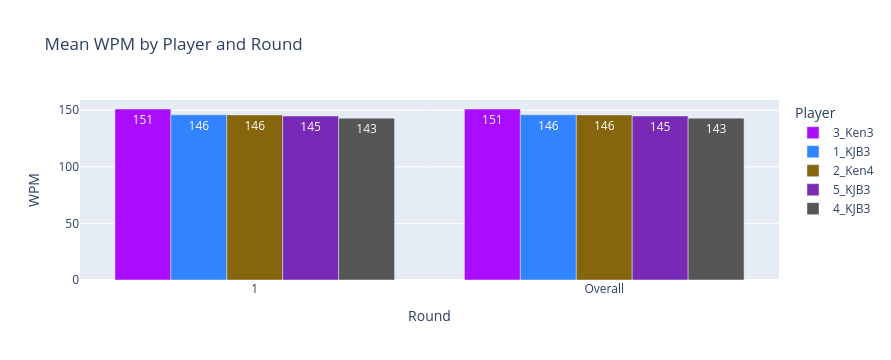

In [11]:
fig_mean_wpm_by_player_and_round = px.bar(
    df_mean_wpm_by_player_and_round.sort_values(
'Overall rank', ascending = True), x = 'Round', 
       y = 'WPM', color = 'Player', barmode = 'group',
    color_discrete_sequence = px.colors.qualitative.Alphabet,
    title = 'Mean WPM by Player and Round',
      text_auto = '.0f', hover_data = 'Overall rank')
fig_mean_wpm_by_player_and_round.write_html(
    f'{mp_visualizations_folder}{test_results_name}_Mean_WPM_\
By_Player_And_Round.html',
    include_plotlyjs = 'cdn')
# fig_mean_wpm_by_player_and_round

In [12]:
df_wins = df.pivot_table(index = 'Player', values = 'Player had best \
WPM for this test', aggfunc = 'sum').reset_index()
df_wins.sort_values('Player had best WPM for this test', ascending = False,
                   inplace = True)
df_wins

,Player,Player had best WPM for this test
1,2_Ken4,4
2,3_Ken3,3
3,4_KJB3,2
0,1_KJB3,1
4,5_KJB3,0


In [13]:
fig_wins = px.bar(df_wins, x = 'Player', 
       y = 'Player had best WPM for this test',
      title = 'Number of Tests in Which Each Player \
Had the Highest WPM', text_auto = '.0f',
                 color = 'Player', 
color_discrete_sequence=px.colors.qualitative.Alphabet).update_layout(
yaxis_title = 'Wins')
fig_wins.write_html(f'{mp_visualizations_folder}{test_results_name}_\
wins_by_player.html', include_plotlyjs = 'cdn')
# fig_wins

In [14]:
df_highest_wpm = df.pivot_table(index = 'Player', values = 'WPM', 
                                aggfunc = 'max').reset_index()
df_highest_wpm.sort_values('WPM', ascending = False, inplace = True)
df_highest_wpm

,Player,WPM
0,1_KJB3,179.484263
1,2_Ken4,174.967876
2,3_Ken3,173.174778
4,5_KJB3,168.399464
3,4_KJB3,166.496865


In [15]:
fig_highest_wpm = px.bar(df_highest_wpm, x = 'Player', 
       y = 'WPM',
      title = 'Highest WPM by Player', text_auto = '.3f',
                 color = 'Player', 
                 color_discrete_sequence = 
px.colors.qualitative.Alphabet)
fig_highest_wpm.write_html(
    f'{mp_visualizations_folder}{test_results_name}_\
highest_wpm_by_player.html', include_plotlyjs = 'cdn')
# fig_highest_wpm

In [16]:
end_time = time.time()
run_time = end_time - start_time
print(f"Finished calculating and visualizing multiplayer stats in \
{round(run_time, 3)} seconds.")

Finished calculating and visualizing multiplayer stats in 0.651 seconds.
